# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
from tqdm.autonotebook import tqdm

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

In [2]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

# read a previously trained LocationModel
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/Visium/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

# Set paths to data and results used through the document:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/oxford_visium/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/'
annotations_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/tissue_annotation/oxford/'
sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/gut/'

regression_model_output = 'v1_ye_signatures_lr0002_Adam'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'
## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

run_name = 'c2l_v3_nonamortised_fulldata_epochs20k_lr0002_Adam_oxford_adult_paed_ref_signatures_N25_alphatest20'
scvi_run_name = f'{results_folder}/{run_name}'

# path for saving figures
fig_path = f'{results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{results_folder}{run_name}/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']


# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

slide = select_slide(adata_vis, 'A1')

mpl.rc_file_defaults()



Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_tc8kk962.c:4:10: fatal error: cudnn.h: No such file or directory\n    4 | #include <cudnn.h>\n      |          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/theano/gpuarray/__init__.py", line 262, in <module>
    use(config.device)
  File "/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/theano/gpuarray/__init__.py", line 251, in use
    optdb.add_tags("gpuarray_opt", "fast_run", "fast_compile")
AttributeError: module 'theano.gpuarray.optdb' has no attribute 'add_tags'
Trying to set attribute `.uns` of view, copying.


In [3]:
# region annotations for each cell type
gold_standard_dict = {
    'Cycling B cell': 'Lymphoid_structure',
    'Naive B': 'Lymphoid_structure',
    'SELL+ CD8 T': 'Lymphoid_structure',
    'SELL+ CD4 T': 'Lymphoid_structure',
    'Treg': 'Lymphoid_structure',
    'T reticular': 'Lymphoid_structure',
    'cDC2': 'Lymphoid_structure',
    'cDC1': 'Lymphoid_structure',
    'Lymphoid DC': 'Lymphoid_structure',
    'DZ GC cell': 'Lymphoid_structure',
    'Tfh': 'Lymphoid_structure',
    'GC B cell': 'Lymphoid_structure',
    'FDC': 'Lymphoid_structure',
    'LZ GC cell': 'Lymphoid_structure',
    'STAT1+ Naive B': 'Lymphoid_structure',
    'FCRL4+ Memory B': 'Lymphoid_structure',
    'Memory B': 'Lymphoid_structure',
    'Activated CD4 T': 'Lymphoid_structure',
    'CD8 Tmem': 'Lymphoid_structure',
} 
gold_standard = pd.DataFrame(gold_standard_dict, index=['label']).T
gold_standard.index = [f'gold_standard_{i}' for i in gold_standard.index]

for ct in gold_standard.index:
    adata_vis.obs[ct] = adata_vis.obs['Annotation'].isin([gold_standard.loc[ct, 'label']]).astype(float)
    
adata_vis.obs[gold_standard.index]

from re import sub
col_ind = [sub('gold_standard_','',i) for i in gold_standard.index]

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

In [4]:
from re import sub
col_ind = [sub('gold_standard_','',i) for i in gold_standard.index]

In [5]:
results_folder_st = f'{results_folder}oxford/rctd/'
RCTD = pd.read_csv(f'{results_folder_st}results_selected_weights_76clusters.csv',
                   index_col='spot')
adata_vis = adata_vis[adata_vis.obs_names.isin(RCTD.index),:]

# compute cell proportions
RCTD = (RCTD.T / RCTD.sum(1)).T
RCTD = RCTD.loc[adata_vis.obs_names,:]

# adata_vis.obs[[f'RCTD_{i}' for i in RCTD.columns]] = RCTD.values

results = [RCTD[col_ind]]
names = ['RCTD']

In [6]:
results_folder_st = f'{results_folder}oxford/scvi_stereoscope_selected_optimised_long/'
scvi_stereoscope = anndata.read(f'{results_folder_st}/stmodel/sp_40k_released.h5ad')

scvi_stereoscope = scvi_stereoscope.obsm['decomposition'].copy()
scvi_stereoscope = (scvi_stereoscope.T / scvi_stereoscope.sum(1)).T
scvi_stereoscope = scvi_stereoscope.loc[adata_vis.obs_names,:]

# adata_vis.obs[[f'scVI_Stereoscope_{i}' for i in scvi_stereoscope.columns]] = scvi_stereoscope.values

results = results + [scvi_stereoscope[col_ind]]
names = names + ['scVI_Stereoscope']

In [7]:
results_folder_st = f'{results_folder}oxford/seurat/'

seurat = pd.read_csv(f'{results_folder_st}results_selected_76clusters_pca.csv', index_col=0)
seurat = seurat.drop(columns=['predicted.id', 'spot', 'prediction.score.max'])

from re import sub
seurat.columns = [sub('prediction\.score\.', '', i) for i in seurat.columns]

def remove_special_characters(df, special_list=[' ', '\(', '\)', '\+', '\\\\', '/', '-', ';'],
                              replace='.'):
    from re import sub
    for s in special_list:
        df = [sub(s, replace, c) for c in df]
            
    return df

inf_aver_copy = adata_vis.uns['mod']['factor_names'].copy()
inf_aver_copy = remove_special_characters(inf_aver_copy)

seurat = seurat[inf_aver_copy]
seurat.columns = adata_vis.uns['mod']['factor_names']

# compute cell proportions
seurat = (seurat.T / seurat.sum(1)).T
seurat = seurat.loc[adata_vis.obs_names,:]

# adata_vis.obs[[f'Seurat_{i}' for i in seurat.columns]] = seurat.values

results = results + [seurat[col_ind]]
names = names + ['Seurat']

In [8]:
results_folder_st = f'{results_folder}oxford/autogenes_models/'
nnls = pd.read_csv(f'{results_folder_st}coef_nnls_selected_seed.csv', index_col=0).T

# compute cell proportions
nnls = (nnls.T / nnls.sum(1)).T
nnls[nnls.isna()] = 0

nnls = nnls.loc[adata_vis.obs_names,:]

# adata_vis.obs[[f'NNSL_{i}' for i in nnls.columns]] = nnls.values

results = results + [nnls[col_ind]]
names = names + ['NNSL']

In [9]:
pos_cell_count = adata_vis.obs[gold_standard.index].values
pos_cell_count_df = adata_vis.obs[gold_standard.index]

cell2loc = adata_vis.obs[adata_vis.uns['mod']['factor_names']]
cell2loc = (cell2loc.T / cell2loc.sum(1)).T

# adata_vis.obs[[f'cell2location_{i}' for i in cell2loc.columns]] = cell2loc.values

results =  [cell2loc[col_ind]] + results
names = ['cell2location'] + names

In [10]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

rows = []

for cell_prop_df, method_name in zip(results, names):
    predictor = cell_prop_df.values + np.random.gamma(20, 1e-12, cell_prop_df.shape)

    mode = 'macro'
    PR_macro = average_precision_score(pos_cell_count, predictor, average=mode)

    mode = 'micro'
    PR_micro = average_precision_score(pos_cell_count, predictor, average=mode)


    rows.append((method_name, PR_macro, PR_micro))
    
other_methods_df = pd.DataFrame(rows, columns=['method_name', 'PR_score_macro', 'PR_score_micro'])

In [11]:
other_methods_df

,method_name,PR_score_macro,PR_score_micro
0,cell2location,0.501485,0.153989
1,RCTD,0.274345,0.188495
2,scVI_Stereoscope,0.015738,0.011437
3,Seurat,0.204908,0.193493
4,NNSL,0.055317,0.039927


In [12]:
# Set paths to data and results used through the document:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/oxford_visium/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/'
annotations_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/tissue_annotation/oxford/'
sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/gut/'

regression_model_output = 'v1_ye_signatures_lr0002_Adam'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'
## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

run_name = 'c2l_v3_nonamortised_fulldata_epochs20k_lr0002_Adam_oxford_adult_paed_ref_signatures_N25_alphatest20'
scvi_run_name = f'{results_folder}/{run_name}'

# path for saving figures
fig_path = f'{results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{results_folder}{run_name}/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

gold_standard = pd.DataFrame(gold_standard_dict, index=['label']).T
gold_standard.index = [f'gold_standard_{i}' for i in gold_standard.index]

for ct in gold_standard.index:
    adata_vis.obs[ct] = adata_vis.obs['Annotation'].isin([gold_standard.loc[ct, 'label']]).astype(float)
    
adata_vis.obs[gold_standard.index]

from re import sub
col_ind = [sub('gold_standard_','',i) for i in gold_standard.index]

In [13]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/hyperparameters/'

In [14]:
folder_names = [i for i in os.listdir(results_folder) if 'test' in i]
res = pd.concat([pd.read_csv(f'{results_folder}/param_tables/table_{i}.csv') for i in range(6)])

In [15]:
res.index = res['names']

### Read and compute R^2 and PR score

In [16]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

for i, f in tqdm(enumerate(folder_names[:])):
    
    sp_data_file = f'{results_folder}/{f}/sp.h5ad'
    adata_vis_res = anndata.read(sp_data_file)

    spot_factors = adata_vis_res.obsm['q05_cell_abundance_w_sf']
    spot_factors.columns = adata_vis_res.uns['mod']['factor_names']
    infer_cell_count = spot_factors[col_ind]

    infer_cell_count_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T
    
    predictor = infer_cell_count.values
    # For each cell type
    mode = 'macro'
    res.loc[f, f'PR_score_{mode}'] = average_precision_score(adata_vis.obs[gold_standard.index].values.astype(bool), predictor, average=mode)
    #res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)
    mode = 'micro'
    res.loc[f, f'PR_score_{mode}'] = average_precision_score(adata_vis.obs[gold_standard.index].values.astype(bool), predictor, average=mode)
    #res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)

0it [00:00, ?it/s]

### Look at stability of inference for relative values

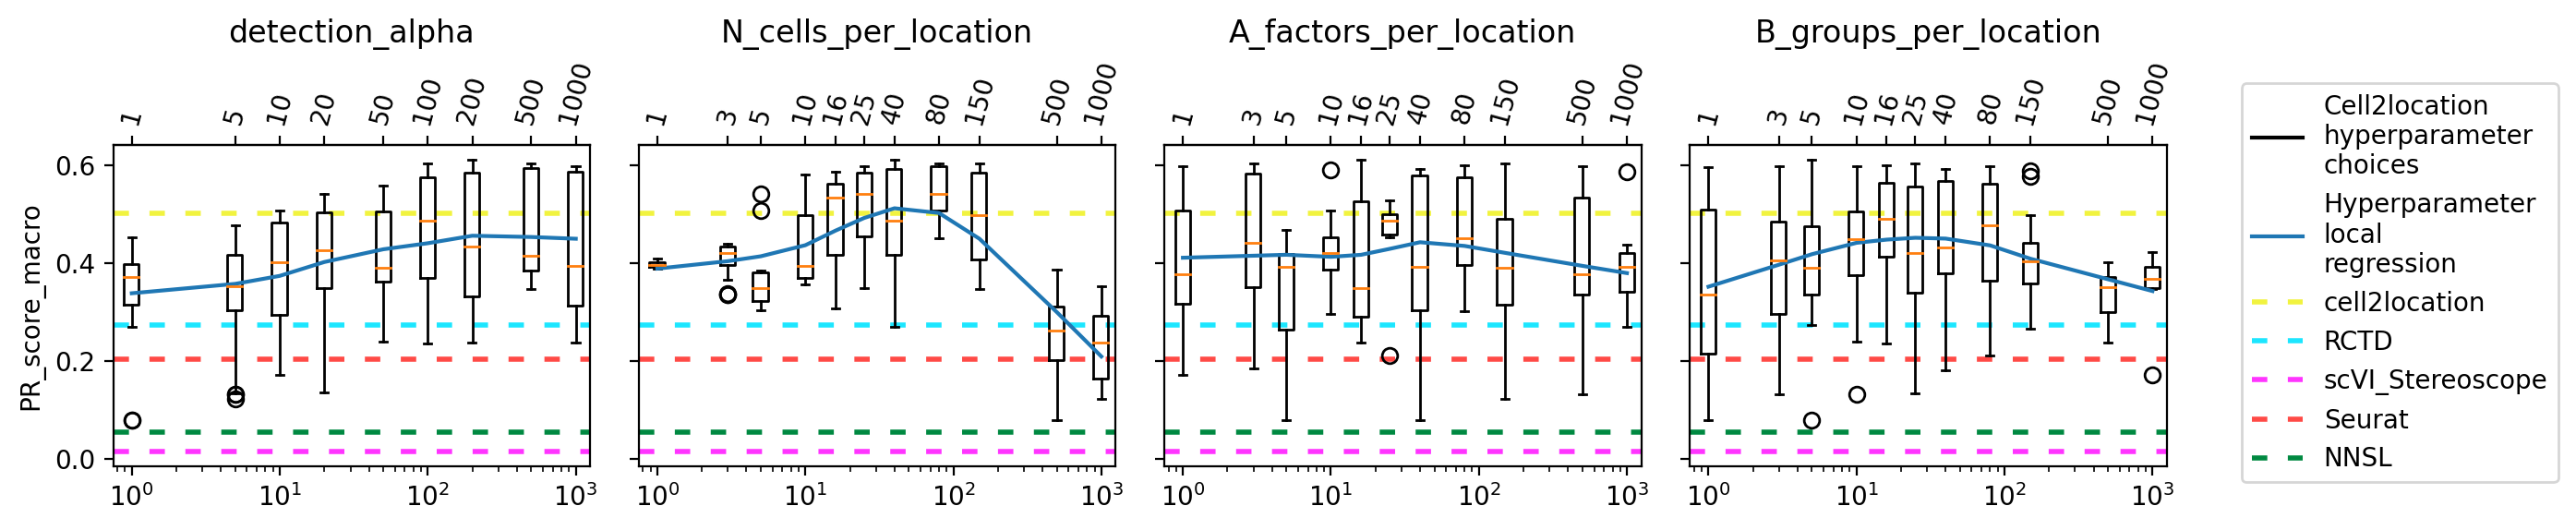

In [19]:
import statsmodels.api as sm


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), sharex=True, sharey='row')
axs = axs[None,]

param_names = ['detection_alpha', 'N_cells_per_location', 'A_factors_per_location', 'B_groups_per_location']
score_names = ['PR_score_macro']

res2 = res.iloc[:, :25].dropna()

for n_score, score_name in enumerate(score_names):
    for n_param, param_name in enumerate(param_names):
        ax = axs[n_score, n_param]
#         ax.scatter(res2[param_name].values.flatten(), res2[score_name].values.flatten())
        gb = res2[[param_name, score_name]].groupby(param_name)
        w = 0.1
        width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
        pos = [i[0] for i in gb]
        values = [i[1][score_name].values for i in gb]
        ax.boxplot(values, positions=pos, widths=width(pos,w))
        ax.plot([], [], color='k', label='Cell2location\nhyperparameter\nchoices')
        lowess_sm = sm.nonparametric.lowess
        yest_sm = lowess_sm(res2[score_name].values.flatten() ,np.log10(res2[param_name].values.flatten()), 
                            frac=1/2, it=5, return_sorted=True)
        ax.plot(10**yest_sm[:, 0], yest_sm[:, 1], color='C0', label='Hyperparameter\nlocal\nregression')
        ax.set_xscale('log')
        if ax.is_first_row():
            ax.set_title(param_name)
            secax_x = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
            secax_x.set_xticks(pos)
            secax_x.set_xticklabels(np.array(pos).astype(int), rotation=75)
            secax_x.minorticks_off()
        if ax.is_first_col():
            ax.set_ylabel(score_name)
        
        x_min, x_max = ax.set_xlim(0.75, 1250)
        
        if score_name in other_methods_df.columns:
            for n, name, score in other_methods_df.loc[:, ['method_name', score_name]].itertuples():
                color = sc.pl.palettes.default_102[n]
                if n == 0:
                    color = 'xkcd:off yellow'
                ax.hlines(score, 0.75, 1250, colors=[color], 
                          linewidth=2, label=name, linestyle=(0, (3, 4)))
        
plt.figlegend(*axs[0,0].get_legend_handles_labels(), bbox_to_anchor=(1.01,0.475), loc="center left")
        
plt.tight_layout()

plt.savefig('stability_local_regression_gut.pdf', bbox_inches='tight')